# Calculate Covergence for SACRA, BAM, THC Resampled Data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.interpolate import UnivariateSpline
from scipy.interpolate import interp1d
from scipy.optimize import fsolve
from scipy.signal import find_peaks, savgol_filter
import glob
import os

In [2]:
def plot_waveform_data(dfs, labels):
    plt.figure(figsize=(10, 6))  # Set figure size for a clear, publication-ready plot

    # Loop over each DataFrame and plot the corresponding data
    for df, label in zip(dfs, labels):
        plt.plot(df['time'], df['Real'], label=label)  # Plot 'time' vs 'Amp'
    
    # Adding labels, title, and legend
    plt.xlabel('Time', fontsize=14)
    plt.ylabel('Real ', fontsize=14)
    #plt.title('Time vs Amplitude for Processed Waveform Data', fontsize=16)
    
    plt.legend(loc='best', fontsize=12)  # Add legend to distinguish datasets
    plt.grid(True)  # Add grid for better readability

    # Improving the appearance for a paper-ready plot
    plt.tight_layout()  # Automatically adjust layout to avoid overlap
#    plt.savefig('waveform_plot.png', dpi=300)  # Save plot as high-resolution PNG
    plt.show()  # Show plot in the output

In [3]:
# Functions to solve for p for given ratio
def find_p_method1(r_cf, r_mf, F_c, F_m, F_f):
    deltaF_fm = F_m - F_f
    deltaF_fc = F_c - F_f
    ratio = (deltaF_fm / deltaF_fc)
    
    def equation(p):
        return (1 - r_mf**p) / (1 - r_cf**p) - ratio
    init_p = 2
    limit = 0.5
    #p_solution = fsolve(equation, initial_guess, maxfev=1000)  # Start with an initial guess of 2
    #return p_solution[0] if p_solution.size > 0 else np.nan
    # Solve for p numerically using the provided initial guess
    p_solution, info, ier, msg = fsolve(equation, init_p, full_output=True)
    if ier == 1:  # Solution found
        return np.abs(p_solution[0])
    else:
        return limit #np.nan  # Return NaN if no solution is found


def find_p_method2(r_cf, r_mf, F_c, F_m, F_f):
    deltaF_fm = F_m - F_f
    deltaF_fc = F_c - F_f
    ratio = (deltaF_fm / deltaF_fc)
    s = np.sign((F_c - F_m) / (F_m - F_f))
    
    def equation(p):
        return (1 - s * r_mf**p) / (1 - r_cf**p) - ratio
    init_p = 2
    limit = 0.5
    #p_solution = fsolve(equation, initial_guess, maxfev=1000)  # Start with an initial guess of 2
    #return p_solution[0] if p_solution.size > 0 else np.nan
    # Solve for p numerically using the provided initial guess
    p_solution, info, ier, msg = fsolve(equation, init_p, full_output=True)
    if ier == 1:  # Solution found
        return np.abs(p_solution[0])
    else:
        return limit #np.nan  # Return NaN if no solution is found

In [4]:
def calculate_convergence(nc, nm, nf, df_coarse, df_medium, df_refined, method, file_name):
    if not (df_coarse['time'].equals(df_medium['time']) and df_medium['time'].equals(df_refined['time'])):
        raise ValueError("Time columns are not aligned.")
    
    F_c = df_coarse['Real']
    F_m = df_medium['Real']
    F_f = df_refined['Real']

    r_cm = nm / nc
    r_cf = nf / nc
    r_mf = nm / nf

    p_list = []

    # Selecting method based on input
    for F_c_value, F_m_value, F_f_value in zip(F_c, F_m, F_f):
        if method == 1:
            p = find_p_method1(r_cf, r_mf, F_c_value, F_m_value, F_f_value)
        elif method == 2:
            p = find_p_method2(r_cf, r_mf, F_c_value, F_m_value, F_f_value)
#        elif method == 3:
#            p = find_p_method3(r_cm, r_mf, F_c_value, F_m_value, F_f_value)
        p_list.append(p)

    results = pd.DataFrame({
        'time': df_coarse['time'],
        'Convergence': p_list
    })

    # Calculating the average convergence p_av
    p_ave = np.mean(p_list)
    print(f"Average convergence order (p_ave):", p_ave)
    

    # Calculating global convergence p_glb
    p_glb = np.mean([min(max(0.05, p), np.abs(p_ave)) for p in p_list])
    print(f"Global convergence order (p_glb):", p_glb)
    

    # Calculating deviation Delta p
    delta_p = min(np.mean([min(np.abs(p_ave - p), 4*p_ave) for p in p_list]), 0.95 * p_ave)
    print(f"Deviation convergence order (delta_p):", delta_p)
    

    # Adding these to the results DataFrame
    #results['p_av'] = p_av
    #results['p_glb'] = p_glb
    #results['Delta_p'] = delta_p

    # Save results to a CSV file
    results.to_csv(file_name, index=False)

    #return results

In [6]:
# Load the resampled data for SACRA
Resampled_df_Fc_1 = pd.read_csv('SACRA/Psi4/R01/SACRA_H_135_135_psi4_resampled.csv')#, index_col='time')
Resampled_df_Fm_1 = pd.read_csv('SACRA/Psi4/R02/SACRA_H_135_135_psi4_resampled.csv')
Resampled_df_Ff_1 = pd.read_csv('SACRA/Psi4/R03/SACRA_H_135_135_psi4_resampled.csv')

Resampled_df_Fc_1p1 = pd.read_csv('SACRA/Psi4/R01/SACRA_H_125_146_psi4_resampled.csv')#, index_col='time')
Resampled_df_Fm_1p1 = pd.read_csv('SACRA/Psi4/R02/SACRA_H_125_146_psi4_resampled.csv')
Resampled_df_Ff_1p1 = pd.read_csv('SACRA/Psi4/R03/SACRA_H_125_146_psi4_resampled.csv')

Resampled_df_Fc_1p2 = pd.read_csv('SACRA/Psi4/R01/SACRA_H_121_151_psi4_resampled.csv')#, index_col='time')
Resampled_df_Fm_1p2 = pd.read_csv('SACRA/Psi4/R02/SACRA_H_121_151_psi4_resampled.csv')
Resampled_df_Ff_1p2 = pd.read_csv('SACRA/Psi4/R03/SACRA_H_121_151_psi4_resampled.csv')

#Resampled_df_Fc_psi4 = pd.read_csv('../SACRA_Catalog/Psi4/Lev_130/SACRA_SFHo_135_135_psi4_resampled.csv')#, index_col='time')
#Resampled_df_Fm_psi4 = pd.read_csv('../SACRA_Catalog/Psi4/Lev_150/SACRA_SFHo_135_135_psi4_resampled.csv')
#Resampled_df_Ff_psi4 = pd.read_csv('../SACRA_Catalog/Psi4/Lev_182/SACRA_SFHo_135_135_psi4_resampled.csv')

In [7]:
# Plot loaded DataFrames
#dfs = [Resampled_df_Fc_psi4, Resampled_df_Fm_psi4, Resampled_df_Ff_psi4]  # List of DataFrames
#labels = ['Coarse', 'Medium', 'Refined']  # Labels for each DataFrame
#plot_waveform_data(dfs, labels)

In [8]:
# Load the resampled data for THC
#Resampled_df_Ff_1 = pd.read_csv('THC/Psi4/R01/THC0088_SFHo_1364_1364_psi4_resampled.csv')#, index_col='time')
#Resampled_df_Fm_1 = pd.read_csv('THC/Psi4/R02/THC0088_SFHo_1364_1364_psi4_resampled.csv')
#Resampled_df_Fc_1 = pd.read_csv('THC/Psi4/R03/THC0088_SFHo_1364_1364_psi4_resampled.csv')

#Resampled_df_Ff_1p1 = pd.read_csv('THC/Psi4/R01/THC0090_SFHo_1452_1283_psi4_resampled.csv')#, index_col='time')
#Resampled_df_Fm_1p1 = pd.read_csv('THC/Psi4/R02/THC0090_SFHo_1452_1283_psi4_resampled.csv')
#Resampled_df_Fc_1p1 = pd.read_csv('THC/Psi4/R03/THC0090_SFHo_1452_1283_psi4_resampled.csv')

#Resampled_df_Ff_1 = pd.read_csv('THC/Psi4/R01/THC0063_BLh_1364_1364_psi4_resampled.csv')#, index_col='time')
#Resampled_df_Fm_1 = pd.read_csv('THC/Psi4/R02/THC0063_BLh_1364_1364_psi4_resampled.csv')
#Resampled_df_Fc_1 = pd.read_csv('THC/Psi4/R03/THC0063_BLh_1364_1364_psi4_resampled.csv')

#Resampled_df_Ff_1p1 = pd.read_csv('THC/Psi4/R01/THC0064_BLh_1581_1184_psi4_resampled.csv')#, index_col='time')
#Resampled_df_Fm_1p1 = pd.read_csv('THC/Psi4/R02/THC0064_BLh_1581_1184_psi4_resampled.csv')
#Resampled_df_Fc_1p1 = pd.read_csv('THC/Psi4/R03/THC0064_BLh_1581_1184_psi4_resampled.csv')

#Resampled_df_Ff_1p2 = pd.read_csv('THC/Psi4/R01/THC0038_BLh_1699_1104_psi4_resampled.csv')#, index_col='time')
#Resampled_df_Fm_1p2 = pd.read_csv('THC/Psi4/R02/THC0038_BLh_1699_1104_psi4_resampled.csv')
#Resampled_df_Fc_1p2 = pd.read_csv('THC/Psi4/R03/THC0038_BLh_1699_1104_psi4_resampled.csv')

In [9]:
# Load the resampled data for BAM
#Resampled_df_Ff_1 = pd.read_csv('BAM/Psi4/R01/BAM0070_MS1b_1375_1375_psi4_resampled.csv')#, index_col='time')
#Resampled_df_Fm_1 = pd.read_csv('BAM/Psi4/R02/BAM0070_MS1b_1375_1375_psi4_resampled.csv')
#Resampled_df_Fc_1 = pd.read_csv('BAM/Psi4/R03/BAM0070_MS1b_1375_1375_psi4_resampled.csv')

#Resampled_df_Ff_1p1 = pd.read_csv('BAM/Psi4/R01/BAM0089_MS1b_1527_1222_psi4_resampled.csv')#, index_col='time')
#Resampled_df_Fm_1p1 = pd.read_csv('BAM/Psi4/R02/BAM0089_MS1b_1527_1222_psi4_resampled.csv')
#Resampled_df_Fc_1p1 = pd.read_csv('BAM/Psi4/R03/BAM0089_MS1b_1527_1222_psi4_resampled.csv')

#Resampled_df_Ff_1p2 = pd.read_csv('BAM/Psi4/R01/BAM0091_MS1b_1650_1100_psi4_resampled.csv')#, index_col='time')
#Resampled_df_Fm_1p2 = pd.read_csv('BAM/Psi4/R02/BAM0091_MS1b_1650_1100_psi4_resampled.csv')
#Resampled_df_Fc_1p2 = pd.read_csv('BAM/Psi4/R03/BAM0091_MS1b_1650_1100_psi4_resampled.csv')

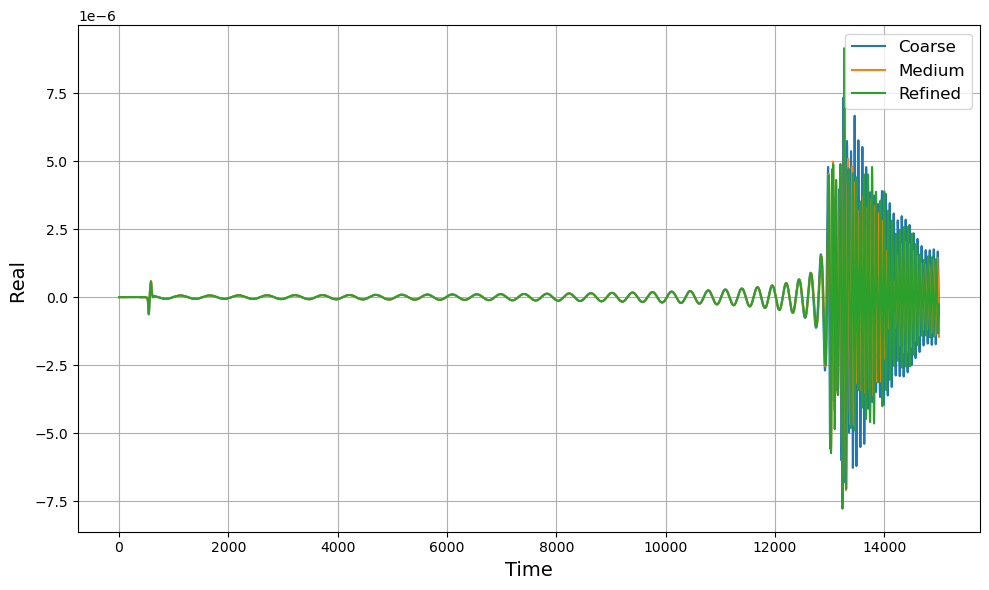

In [10]:
# Plot loaded DataFrames
dfs = [Resampled_df_Fc_1, Resampled_df_Fm_1, Resampled_df_Ff_1]  # List of DataFrames
labels = ['Coarse', 'Medium', 'Refined']  # Labels for each DataFrame
plot_waveform_data(dfs, labels)

In [11]:
nc = 130; nm = 150; nf = 182
file_name = 'SACRA_H_135_135_psi4_conv_1'
#nc = 1/0.167; nm = 1/0.125; nf = 1/0.083
#file_name = 'THC0088_SFHo_1364_1364_psi4_conv_1'
#nc = 1/0.25; nm = 1/0.167; nf = 1/0.125
#nc = 1/0.231; nm = 1/0.154; nf = 1/0.116
#file_name = 'BAM0070_MS1b_1375_1375_psi4_conv_1'
method = 1
calculate_convergence(nc, nm, nf, Resampled_df_Fc_1, Resampled_df_Fm_1, Resampled_df_Ff_1, method, file_name)

Average convergence order (p_ave): 2.0259499773986884
Global convergence order (p_glb): 1.2482797342766336
Deviation convergence order (delta_p): 1.5253188743804134


In [12]:
method = 2
file_name = 'SACRA_H_135_135_psi4_conv_2'
calculate_convergence(nc, nm, nf, Resampled_df_Fc_1, Resampled_df_Fm_1, Resampled_df_Ff_1, method, file_name)

Average convergence order (p_ave): 3.420552221316545
Global convergence order (p_glb): 2.3771440479920973
Deviation convergence order (delta_p): 2.0831622159165546


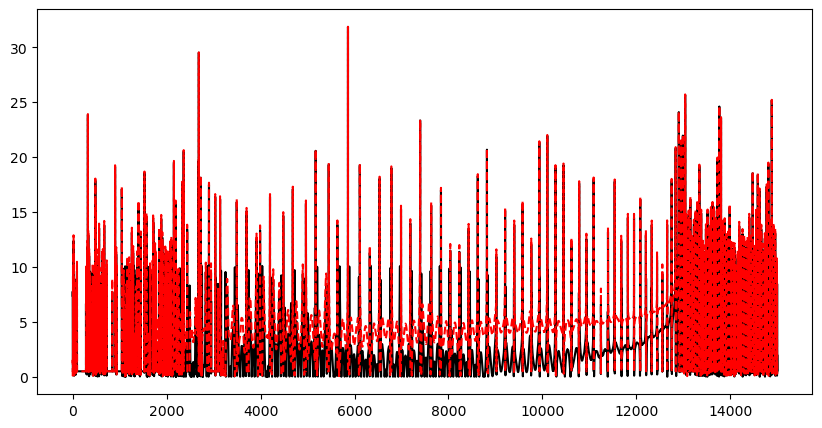

In [13]:
df_convergence_1 = pd.read_csv('SACRA_H_135_135_psi4_conv_1')
df_convergence_2 = pd.read_csv('SACRA_H_135_135_psi4_conv_2')
plt.figure(figsize=(10, 5))
plt.plot(df_convergence_1['time'], df_convergence_1['Convergence'], label='p', color='black')
plt.plot(df_convergence_2['time'], df_convergence_2['Convergence'], label='p', color='red', linestyle= '--')

In [14]:
file_name = 'SACRA_H_125_146_psi4_conv_1'
#file_name = 'BAM0089_MS1b_1527_1222_psi4_conv_1'
method = 1
calculate_convergence(nc, nm, nf, Resampled_df_Fc_1p1, Resampled_df_Fm_1p1, Resampled_df_Ff_1p1, method, file_name)

Average convergence order (p_ave): 1.8375167116833333
Global convergence order (p_glb): 0.9692693092468949
Deviation convergence order (delta_p): 1.6957260563704077


In [15]:
file_name = 'SACRA_H_125_146_psi4_conv_2'
#file_name = 'BAM0089_MS1b_1527_1222_psi4_conv_2'
method = 2
calculate_convergence(nc, nm, nf, Resampled_df_Fc_1p1, Resampled_df_Fm_1p1, Resampled_df_Ff_1p1, method, file_name)

Average convergence order (p_ave): 2.057914540821509
Global convergence order (p_glb): 1.1671610988889722
Deviation convergence order (delta_p): 1.7512294874752652


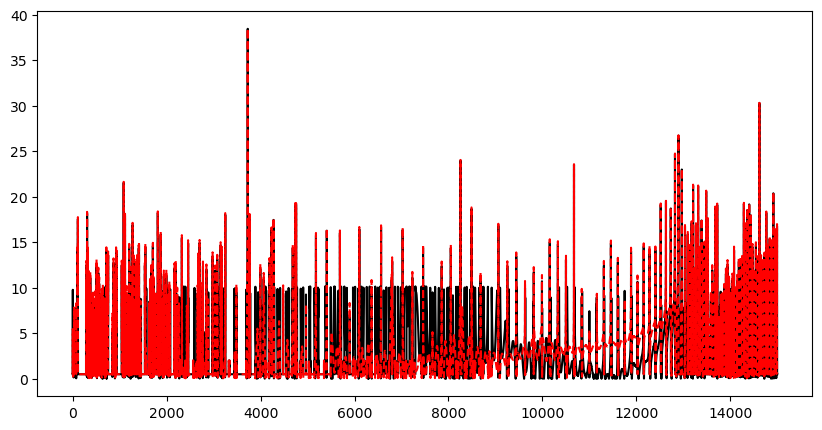

In [16]:
df_convergence_1 = pd.read_csv('SACRA_H_125_146_psi4_conv_1')
df_convergence_2 = pd.read_csv('SACRA_H_125_146_psi4_conv_2')
plt.figure(figsize=(10, 5))
plt.plot(df_convergence_1['time'], df_convergence_1['Convergence'], label='p', color='black')
plt.plot(df_convergence_2['time'], df_convergence_2['Convergence'], label='p', color='red', linestyle= '--')

In [17]:
file_name = 'SACRA_H_121_151_psi4_conv_1'
#file_name = 'BAM0091_MS1b_1650_1100_psi4_conv_1'
method = 1
calculate_convergence(nc, nm, nf, Resampled_df_Fc_1p2, Resampled_df_Fm_1p2, Resampled_df_Ff_1p2, method, file_name)

Average convergence order (p_ave): 0.8582500425221815
Global convergence order (p_glb): 0.5287607556679903
Deviation convergence order (delta_p): 0.534920850580227


In [18]:
file_name = 'SACRA_H_121_151_psi4_conv_2'
#file_name = 'BAM0091_MS1b_1650_1100_psi4_conv_2'
method = 2
calculate_convergence(nc, nm, nf, Resampled_df_Fc_1p2, Resampled_df_Fm_1p2, Resampled_df_Ff_1p2, method, file_name)

Average convergence order (p_ave): 0.8922299169260783
Global convergence order (p_glb): 0.5343091255599357
Deviation convergence order (delta_p): 0.5888279238065788


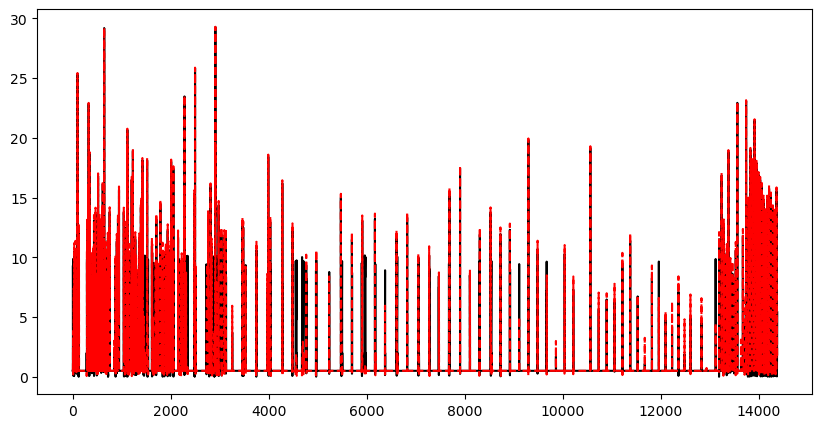

In [19]:
df_convergence_1 = pd.read_csv('SACRA_H_121_151_psi4_conv_1')
df_convergence_2 = pd.read_csv('SACRA_H_121_151_psi4_conv_2')
plt.figure(figsize=(10, 5))
plt.plot(df_convergence_1['time'], df_convergence_1['Convergence'], label='p', color='black')
plt.plot(df_convergence_2['time'], df_convergence_2['Convergence'], label='p', color='red', linestyle= '--')